### import the pkgs and functions

In [1]:
import xlrd
from rdkit import Chem
from rdkit.Chem import AllChem
from docopt import docopt
import numpy as np
from rdkit.Chem import rdMMPA
import sys
import csv
from joblib import Parallel, delayed
import sys
sys.path.append('../') # change the path to the fold of FFLOM in your computer #TODO

from utils import *
import rdkit_conf_parallel

In [2]:
def dataset_info(dataset): 
    if dataset=='zinc':
        return { 'atom_types': ['Br1(0)', 'C4(0)', 'Cl1(0)', 'F1(0)', 'H1(0)', 'I1(0)',
                'N2(-1)', 'N3(0)', 'N4(1)', 'O1(-1)', 'O2(0)', 'S2(0)','S4(0)', 'S6(0)'],
                 'maximum_valence': {0: 1, 1: 4, 2: 1, 3: 1, 4: 1, 5:1, 6:2, 7:3, 8:4, 9:1, 10:2, 11:2, 12:4, 13:6},
                 'number_to_atom': {0: 'Br', 1: 'C', 2: 'Cl', 3: 'F', 4: 'H', 5:'I', 6:'N', 7:'N', 8:'N', 9:'O', 10:'O', 11:'S', 12:'S', 13:'S'},
               }
    else:
        exit(1)

In [3]:
def check_smi_atom_types(smi, dataset='zinc', verbose=False):
    mol = Chem.MolFromSmiles(smi)
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        valence = atom.GetTotalValence()
        charge = atom.GetFormalCharge()
        atom_str = "%s%i(%i)" % (symbol, valence, charge)

        if atom_str not in dataset_info(dataset)['atom_types']:
            if "*" in atom_str:
                continue
            else:
                if verbose:
                    print('unrecognized atom type %s' % atom_str)
                return False
    return True

### load molecules from .xls file

In [4]:
input_path = 'Input_SMILES.xls' # use your xls file of molecules
output_path = 'Output_SMILES.txt'
verbose = True
design_task = 'elaboration'
n_cores = 4
successes = []
linker_min = 3
fragment_min = 3
min_path_length = 2
linker_leq_frags = True
coun = 0
num = 0

In [5]:
xl = xlrd.open_workbook(input_path) # use your xls file of molecules
table = xl.sheets()[0]
col = table.col_values(0,0) # (0,0) should be adjusted according to the position of data in xls
col

['CC(=O)N(C)Cc1ccc(-c2cc(O[C@H](C)[C@H]3CNC(=O)C3)c3cccnc3c2)cc1']

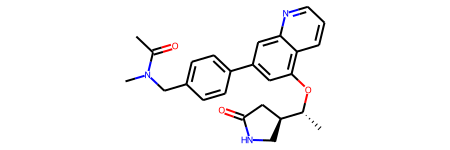

In [6]:
Chem.MolFromSmiles(col[0])

In [7]:
smiles_filt = []
errors = 0
for i, smi in enumerate(col):
    if check_smi_atom_types(smi):
        smiles_filt.append(smi)
    else:
        errors += 1
print("Original num entries: \t\t\t%d" % len(col))
print("Number with permitted atom types: \t%d" % len(smiles_filt))
print("Number of errors: \t\t\t%d" % errors)

Original num entries: 			1
Number with permitted atom types: 	1
Number of errors: 			0


### cut and process

In [8]:
for count, smi in enumerate(smiles_filt):
    smi = smi.rstrip()
    smiles = smi
    cmpd_id = smi

    # Fragment smi
    o = fragment_mol(smiles, cmpd_id, design_task = design_task)
    
    for l in o:
        smiles = l.replace('.',',').split(',')
        mols = [Chem.MolFromSmiles(smi) for smi in smiles[1:]]
        if design_task == "elaboration":
            #If the chopped portion is bigger than the fragment then we need to switch them around
            if mols[2].GetNumHeavyAtoms() < mols[1].GetNumHeavyAtoms():
                smilesNew = [smiles[0], smiles[1], smiles[3], smiles[2]]
                mols = [Chem.MolFromSmiles(smi) for smi in smilesNew[1:]]
                l = ','.join(smilesNew)
        add = True
        fragment_sizes = []
        num += 1
        for i, mol in enumerate(mols):
            # Linker
            if i == 1:
                linker_size = mol.GetNumHeavyAtoms()
                # Check linker at least minimum size
                if linker_size < linker_min:
                    add = False
                    break
                # Check path between the fragments at least minimum
                if design_task =="linker":
                    dummy_atom_idxs = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 0]
                    if len(dummy_atom_idxs) != 2:
                        coun += 1
                        #print(num, coun)
                        add = False
                        break
                    else:
                        path_length = len(Chem.rdmolops.GetShortestPath(mol, dummy_atom_idxs[0], dummy_atom_idxs[1]))-2
                        if path_length < min_path_length:
                            add = False
                            break
            elif i > 1:
                fragment_sizes.append(mol.GetNumHeavyAtoms())
                min_fragment_size = min(fragment_sizes)
                # Check fragment at least than minimum size
                if mol.GetNumHeavyAtoms() < fragment_min:
                    add = False
                    break
                if linker_leq_frags:
                    # Check linker not bigger than fragments
                    if design_task=="linker":
                        if min_fragment_size < linker_size:
                            add = False
                            break
                    # Check elaboration not more than half size of core
                    elif design_task=="elaboration":
                        if min_fragment_size < linker_size*2:
                            add = False
                            break
        if add == True:
            successes.append(l)

fragmentations = []
for suc in successes:
    fragmentations.append(suc.replace('.',',').split(',')[1:])
print("Processed smiles: \t%d" % len(smiles_filt))
print("Num fragmentations: \t%d" % len(fragmentations))

Processed smiles: 	1
Num fragmentations: 	5


In [9]:
pains_smarts_loc = "wehi_pains.csv"
# Filter fragmentions based on 2D properties
with open(pains_smarts_loc, 'r') as f:
    pains_smarts = [Chem.MolFromSmarts(line[0], mergeHs=True) for line in csv.reader(f)]
    
fragmentations_filt = []
for count, toks in enumerate(fragmentations):
    frags = Chem.MolFromSmiles(toks[2])
    linker = Chem.MolFromSmiles(toks[1])
    full_mol = Chem.MolFromSmiles(toks[0])
    # Remove dummy atoms from unlinked fragments
    du = Chem.MolFromSmiles('*')
    clean_frag = Chem.RemoveHs(AllChem.ReplaceSubstructs(frags,du,Chem.MolFromSmiles('[H]'),True)[0])
    res = 0
    # Check: Unlinked fragments in full molecule
    if len(full_mol.GetSubstructMatch(clean_frag))>0:
        # Check: SA score improved from unlinked fragments to full molecule
        if calc_sa_score_mol(full_mol) < calc_sa_score_mol(frags):
            res+=1
        # Check: No non-aromatic rings with double bonds
        if check_ring_filter(linker): 
            res+=1
        # Check: Pass pains filters
        if check_pains(full_mol, pains_smarts):
            res+=1
    if res==3:
        fragmentations_filt.append(toks)

print("Number fragmentations: \t\t%d" % len(fragmentations))
print("Number passed 2D filters: \t%d" % len(fragmentations_filt))

Number fragmentations: 		5
Number passed 2D filters: 	2


In [10]:
fragmentations_filt[0]

['CC(=O)N(C)Cc1ccc(-c2cc(O[C@H](C)[C@H]3CNC(=O)C3)c3cccnc3c2)cc1',
 'CC(=O)N(C)[*:1]',
 'C[C@@H](Oc1cc(-c2ccc(C[*:1])cc2)cc2ncccc12)[C@H]1CNC(=O)C1']

In [11]:
with open(output_path, 'w') as f:
    if design_task == 'linker': 
        for fragmentation in fragmentations_filt:
            f.write("%s %s %s\n" % (fragmentation[0], fragmentation[1], fragmentation[2]+'.'+fragmentation[3]))
    else: # 'elaboration'
        for fragmentation in fragmentations_filt:
            f.write("%s %s %s\n" % (fragmentation[0], fragmentation[1], fragmentation[2]))

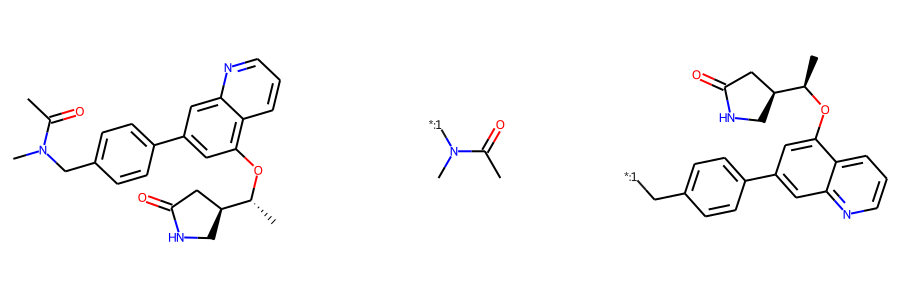

In [12]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in [fragmentations_filt[0][0], fragmentations_filt[0][1], fragmentations_filt[0][2]]], molsPerRow=3, subImgSize=(300,300), 
                            legends='') 

In [13]:
processed_data =[]
error = 0
smi_mol = fragmentations_filt[0][0]
smi_elab = fragmentations_filt[0][1]
smi_frags = fragmentations_filt[0][2]
(mol_out, mol_in), nodes_to_keep, exit_points = align_mol_to_frags_elaboration(smi_mol, smi_frags)
if mol_out == []:
    error = 1
nodes_in, edges_in = to_graph_mol(mol_in, 'zinc')
nodes_out, edges_out = to_graph_mol(mol_out, 'zinc')
if min(len(edges_in), len(edges_out)) <= 0:
    error = 1
processed_data.append({
        'graph_in': edges_in,
        'graph_out': edges_out, 
        'node_features_in': nodes_in,
        'node_features_out': nodes_out, 
        'smiles_out': smi_mol,
        'smiles_in': smi_frags,
        'v_to_keep': nodes_to_keep,
        'exit_points': exit_points
    })
error

0

In [14]:
import torch
atom = 89
node = 14
full_nodes = []
full_edges = []
linker_len = []
for line in processed_data:
    full_node=torch.zeros([atom, node])
    for i in range(len(line['node_features_out'])):
        for j in range(len(line['node_features_out'][0])):
            full_node[i][j]=line['node_features_out'][i][j]
    full_nodes.append(full_node)
    full_edge=torch.zeros([4,atom,atom])
    for i in (line['graph_out']):
        start=i[0]
        end=i[2]
        edge=i[1]
        full_edge[edge,start,end]=1.0
        full_edge[edge,end,start]=1.0
    full_edges.append(full_edge)
    linker_len.append(len(line['node_features_out'])-len(line['node_features_in']))
print(len(full_nodes), full_nodes[0].shape, full_edges[0].shape, linker_len[0])

1 torch.Size([89, 14]) torch.Size([4, 89, 89]) 5


In [15]:
frag_nodes=[]
frag_edges=[]
for line in processed_data:
    frag_node=torch.zeros([atom, node])
    for i in range(len(line['node_features_in'])):
        for j in range(len(line['node_features_in'][0])):
            frag_node[i][j]=line['node_features_in'][i][j]
    frag_nodes.append(frag_node)
    frag_edge=torch.zeros([4,atom,atom])
    for i in (line['graph_in']):
        start=i[0]
        end=i[2]
        edge=i[1]
        frag_edge[edge,start,end]=1.0
        frag_edge[edge,end,start]=1.0
    frag_edges.append(frag_edge)
len(frag_nodes)

1

In [16]:
full_nodes=torch.tensor([item.detach().numpy() for item in full_nodes])
full_edges=torch.tensor([item.detach().numpy() for item in full_edges])
frag_nodes=torch.tensor([item.detach().numpy() for item in frag_nodes])
frag_edges=torch.tensor([item.detach().numpy() for item in frag_edges])

v_to_keep=[]
exit_point=[]
full_smi=[]
frag=[]
for line in processed_data:
    v_to_keep.append(line['v_to_keep'][-1])
    exit_point.append(line['exit_points'])
    full_smi.append(line['smiles_out'])
    frag.append(line['smiles_in'])
print(exit_point[0],v_to_keep[0],full_smi[0],frag[0])

[25] 25 CC(=O)N(C)Cc1ccc(-c2cc(O[C@H](C)[C@H]3CNC(=O)C3)c3cccnc3c2)cc1 C[C@@H](Oc1cc(-c2ccc(C[*:1])cc2)cc2ncccc12)[C@H]1CNC(=O)C1


c:\Users\32508\.conda\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [17]:
# save the processed data
import numpy as np
path = './' 
np.save(path+'full_nodes', full_nodes)
np.save(path+'full_edges', full_edges)
np.save(path+'frag_nodes', frag_nodes)
np.save(path+'frag_edges', frag_edges)
np.save(path+'gen_len', linker_len)
np.save(path+'v_to_keep', v_to_keep)
np.save(path+'exit_point', exit_point)
np.save(path+'full_smi', full_smi)
np.save(path+'frag', frag)
fp = open(path + 'config.txt', 'w')
config = dict()
config['atom_list'] = {0: 'Br', 1: 'C', 2: 'Cl', 3: 'F', 4: 'H', 5: 'I', 6: 'N', 7: 'N', 8: 'N', 9: 'O', 10: 'O', 11: 'S', 12: 'S', 13: 'S'}
config['freedom'] = 0
config['node_dim'] = 14
config['max_size'] = 89
config['bond_dim'] = 3 + 1
fp.write(str(config))
fp.close()

### generate

In [18]:
import argparse
from torch.utils.data import DataLoader
from train import Trainer, read_molecules
from dataloader import CondDataset
import environment as env

c:\Users\32508\.conda\envs\my-rdkit-env\lib\importlib\_bootstrap.py:219: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterCatalogEntry const > already registered; second conversion method ignored.
  return f(*args, **kwds)


In [20]:
parser = argparse.ArgumentParser(description='FFLOM model')
# ******data args******
parser.add_argument('--path', type=str, help='path of dataset', required=True)
parser.add_argument('--batch_size', type=int, default=32, help='batch_size.')
parser.add_argument('--edge_unroll', type=int, default=12, help='max edge to model for each node in bfs order.')
parser.add_argument('--shuffle', action='store_true', default=True, help='shuffle data for each epoch')
parser.add_argument('--num_workers', type=int, default=10, help='num works to generate data.')

# ******model args******
parser.add_argument('--name', type=str, default='base', help='model name, crucial for test and checkpoint initialization')
parser.add_argument('--deq_type', type=str, default='random', help='dequantization methods.')
parser.add_argument('--deq_coeff', type=float, default=0.9, help='dequantization coefficient.(only for deq_type random)')
parser.add_argument('--num_flow_layer', type=int, default=12, help='num of affine transformation layer in each timestep')
parser.add_argument('--gcn_layer', type=int, default=3, help='num of rgcn layers')
#TODO: Disentangle num of hidden units for gcn layer, st net layer.
parser.add_argument('--nhid', type=int, default=128, help='num of hidden units of gcn')
parser.add_argument('--nout', type=int, default=128, help='num of out units of gcn')

parser.add_argument('--st_type', type=str, default='exp', help='architecture of st net, choice: [sigmoid, exp, softplus, spine]')

# ******for sigmoid st net only ******
parser.add_argument('--sigmoid_shift', type=float, default=2.0, help='sigmoid shift on s.')


# ******optimization args******
parser.add_argument('--all_save_prefix', type=str, default='./', help='path of save prefix')
parser.add_argument('--no_cuda', action='store_true', default=False, help='Disables CUDA training.')
parser.add_argument('--learn_prior', action='store_true', default=False, help='learn log-var of gaussian prior.')

parser.add_argument('--seed', type=int, default=2019, help='Random seed.')
parser.add_argument('--init_checkpoint', type=str, default=None, help='initialize from a checkpoint, if None, do not restore')
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate.')
parser.add_argument('--warm_up', action='store_true', default=True, help='Add warm-up and decay to the learning rate.')
parser.add_argument('--weight_decay', type=float, default=0.0, help='Weight decay.')
parser.add_argument('--dropout', type=float, default=0.0, help='Dropout rate (1 - keep probability).')
parser.add_argument('--is_bn', action='store_true', default=True, help='batch norm on node embeddings.')
parser.add_argument('--is_bn_before', action='store_true', default=False, help='batch norm on node embeddings on st-net input.')
parser.add_argument('--scale_weight_norm', action='store_true', default=False, help='apply weight norm on scale factor.')
parser.add_argument('--divide_loss', action='store_true', default=True, help='divide loss by length of latent.')

# ******generation args******
parser.add_argument('--temperature', type=float, default=0.7, help='temperature for normal distribution')
parser.add_argument('--min_atoms', type=int, default=5, help='minimum #atoms of generated mol, otherwise the mol is simply discarded')
parser.add_argument('--max_atoms', type=int, default=89, help='maximum #atoms of generated mol')    
parser.add_argument('--gen_num', type=int, default=100, help='num of molecules to generate on each call to train.generate')
parser.add_argument('--gen_out_path', type=str, help='output path for generated mol')
parser.add_argument('--len_freedom_x', type=int, default=0, help='the minimum adjust of generated length')
parser.add_argument('--len_freedom_y', type=int, default=0, help='the maximum adjust of generated length')

#TODO
args = parser.parse_args(args=['--path','./',\
    '--gen_out_path','./generate.txt','--batch_size','1','--seed','66666666',\
    '--init_checkpoint','../good_ckpt/checkpoint335','--gen_num','10',\
    ])
args.cuda = not args.no_cuda and torch.cuda.is_available()
set_seed(args.seed, args.cuda)

set seed for random numpy and torch


In [21]:
full_nodes, full_edges, frag_nodes,frag_edges, gen_len, v_to_keep, exit_point, full_smi, data_config = read_molecules(args.path)
train_dataloader = DataLoader(CondDataset(full_nodes, full_edges, frag_nodes,frag_edges,gen_len, exit_point, v_to_keep, full_smi),
                                batch_size = args.batch_size, shuffle = args.shuffle, num_workers = args.num_workers)
trainer = Trainer(train_dataloader, data_config, args, all_train_smiles = full_smi)
checkpoint = torch.load(args.init_checkpoint)
trainer._model.load_state_dict(checkpoint['model_state_dict'], strict=False)
trainer._model.eval()
temperature = args.temperature
max_size = trainer.max_size # 89
node_dim = trainer.node_dim # 14
bond_dim = trainer.bond_dim # 4
num2bond =  {0: Chem.rdchem.BondType.SINGLE, 1: Chem.rdchem.BondType.DOUBLE, 2: Chem.rdchem.BondType.TRIPLE}
num2bond_symbol =  {0: '=', 1: '==', 2: '==='}
num2symbol = {0: 'Br', 1: 'C', 2: 'Cl', 3: 'F', 4: 'H', 5: 'I', 6: 'N', 
                        7: 'N', 8: 'N', 9: 'O', 10: 'O', 11: 'S', 12: 'S', 13: 'S'}
maximum_valence = {0: 1, 1: 4, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 3, 8: 4, 9: 1, 10: 2, 11: 2, 12: 4,
                                13: 6, 14: 3}

reading data from ./
latent node length: 1246
latent edge length: 3960
using 1 GPUs


In [22]:
def generate_one_mol(num,len_freedom=0):
    traj=[]
    error=[]
    node_symbol=[]
    for i in frag_nodes[num]:
        if max(i)>0:
            node_symbol.append(np.argmax(i))

    # initial frag input
    rw_mol = Chem.RWMol()
    valences = [maximum_valence[s] for s in node_symbol]
    #add atoms
    for number in node_symbol:
        new_atom = Chem.Atom(num2symbol[number])
        charge_num=int(atom_types[number].split('(')[1].strip(')'))
        new_atom.SetFormalCharge(charge_num)
        rw_mol.AddAtom(new_atom)
    #add edges
    for bond in range(bond_dim): # (4,89,89)
        for start in range(max_size):
            for end in range(start+1, max_size):
                if frag_edges[num][bond][start][end] == 1:
                    rw_mol.AddBond(start, end, num2bond[bond])

    # update valences
    for i in range(len(node_symbol)):
        if i not in exit_point[num]:
            valences[i] = 0
        else:
            valences[i] = 1

    cur_node_features = torch.tensor(frag_nodes[num]).unsqueeze(0).cuda() # (1,89,14)
    cur_adj_features = torch.tensor(frag_edges[num]).unsqueeze(0).cuda() # (1,4,89,89)

    new_nodes=[i for i in range(len(node_symbol),(len(node_symbol)+gen_len[num]+len_freedom))] 
    cur_node_features_save = cur_node_features.clone()
    cur_adj_features_save = cur_adj_features.clone()
    valences_save = copy.deepcopy(valences)
    #start generating
    for i,new_node in enumerate(new_nodes): #[20,21,22,23]
        flag=True
        while flag==True:
            flag=False
            max_x=0
            while max_x < 1:
                latent_node = prior_node_dist.sample().view(1, -1) #(1, 14)
                latent_node = trainer._model.flow_core.module.reverse(cur_node_features, cur_adj_features, 
                                                        latent_node, mode=0).view(-1) # (14, )
                max_x = max(latent_node)
            feature_id = torch.argmax(latent_node).item()
            cur_node_features[0, new_node, feature_id] = 1.0
            add_atoms(rw_mol, [feature_id])
            traj.append([new_node, num2symbol[feature_id]])
            new_edges=[i for i,x in enumerate(valences) if x > 0][1:] #skip one exit point

            valences.append(maximum_valence[feature_id])
            max_y=0
            bond_num=[]
            while len(new_edges)>0:#
                edge_p=[]
                for new_edge in new_edges: #[19,20]
                    latent_edge = prior_edge_dist.sample().view(1, -1) #(1, 4)
                    latent_edge = trainer._model.flow_core.module.reverse(cur_node_features, cur_adj_features, latent_edge, 
                                                    mode=1, edge_index=torch.Tensor([[new_edge, new_node]]).long().cuda()).view(-1)[:3]
                    for a,x in enumerate(latent_edge):
                        if a >= valences[new_edge] or a >= valences[new_node] or x<0:
                            latent_edge[a] *= 0
                    edge_p.append(latent_edge)
                max_y = max([max(e) for e in edge_p])
                #print(max_y)
                index=torch.argmax(torch.tensor([max(e) for e in edge_p])).item()
                edge_discrete_id = torch.argmax(torch.tensor(edge_p[index])).item()
                if max_y < 1 and len(bond_num) > 0 :
                    break
                
                chosen_edge=new_edges[index]
                traj.append([new_node, chosen_edge, edge_discrete_id])
                valences[new_node] -= (edge_discrete_id + 1)
                valences[chosen_edge] -= (edge_discrete_id + 1)
                new_edges.remove(chosen_edge)
                rw_mol.AddBond(int(new_node),int(chosen_edge),num2bond[edge_discrete_id])
                bond_num.append([int(new_node),int(chosen_edge)])
                #valid = env.check_valency(rw_mol)
                cur_adj_features[0, edge_discrete_id, new_node, chosen_edge] = 1.0
                cur_adj_features[0, edge_discrete_id, chosen_edge, new_node] = 1.0
            if [i for i,x in enumerate(valences) if x > 0][1:]==[] :
                flag=True
                for b in bond_num:
                    rw_mol.RemoveBond(b[0],b[1])
                rw_mol.RemoveAtom(int(new_node))
                valences = copy.deepcopy(valences_save)
                cur_node_features = cur_node_features_save.clone()
                cur_adj_features = cur_adj_features_save.clone()
            else:
                valences_save = copy.deepcopy(valences)
                cur_node_features_save = cur_node_features.clone()
                cur_adj_features_save = cur_adj_features.clone()

    # connect exit_point
    new_edges=[i for i,x in enumerate(valences) if x > 0][1:]
    #max_y = 0

    edge_p=[]
    for new_edge in new_edges:#[19,20]
        latent_edge = prior_edge_dist.sample().view(1, -1) #(1, 4)
        latent_edge = trainer._model.flow_core.module.reverse(cur_node_features, cur_adj_features, latent_edge, 
                                        mode=1, edge_index=torch.Tensor([[new_edge, min(exit_point[num])]]).long().cuda()).view(-1)[:3]

        edge_p.append(latent_edge[0]) #only add single bond for the second exitpoint
    if edge_p==[] : #no valences remain
        error.append(0)
        return None,error
    #max_y = max([max(e) for e in edge_p])
    index=torch.argmax(torch.tensor(edge_p)).item()
    chosen_edge=new_edges[index]
    #new_edges.remove(chosen_edge)
    rw_mol.AddBond(int(min(exit_point[num])),int(chosen_edge),num2bond[0])
    traj.append([min(exit_point[num]), chosen_edge, 0])


    mol = rw_mol.GetMol()
    final_mol = env.convert_radical_electrons_to_hydrogens(mol)
    smiles = Chem.MolToSmiles(final_mol, isomericSmiles=False)
    if '.' in smiles or Chem.MolFromSmiles(smiles)==None:
        return None,traj

    return smiles,[]

In [23]:
import re
import copy
with torch.no_grad():
    frag = np.load(args.path + 'frag.npy')
    smiles=[]
    recon = 0
    novel = 0
    repeat = args.gen_num
    len_freedom = range(args.len_freedom_x, args.len_freedom_y + 1)
    print('start generating %s * %s * %s mols' % (len(frag_nodes), repeat, len(len_freedom)))#

    for idx in range(len(frag_nodes)):#
        # flag = False
        for f in len_freedom:#
            #print('now len freedom = '+ str(f))
            full = []
            fail = 0
            while len(full) < repeat:
                prior_node_dist = torch.distributions.normal.Normal(torch.zeros([node_dim]).cuda(), 
                                        temperature * torch.ones([node_dim]).cuda())
                prior_edge_dist = torch.distributions.normal.Normal(torch.zeros([bond_dim]).cuda(), 
                                        temperature * torch.ones([bond_dim]).cuda())
                smile,_ = generate_one_mol(idx,f)
                if smile != None:
                    smiles.append(smile)
                    full.append([frag[idx], full_smi[idx], smile])
            print('%s: freedom:%s | unique:%.5f '%(idx+1, f, len(set(smiles)) / len(smiles)))


start generating 1 * 10 * 1 mols


c:\Users\32508\.conda\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1: freedom:0 | unique:1.00000 


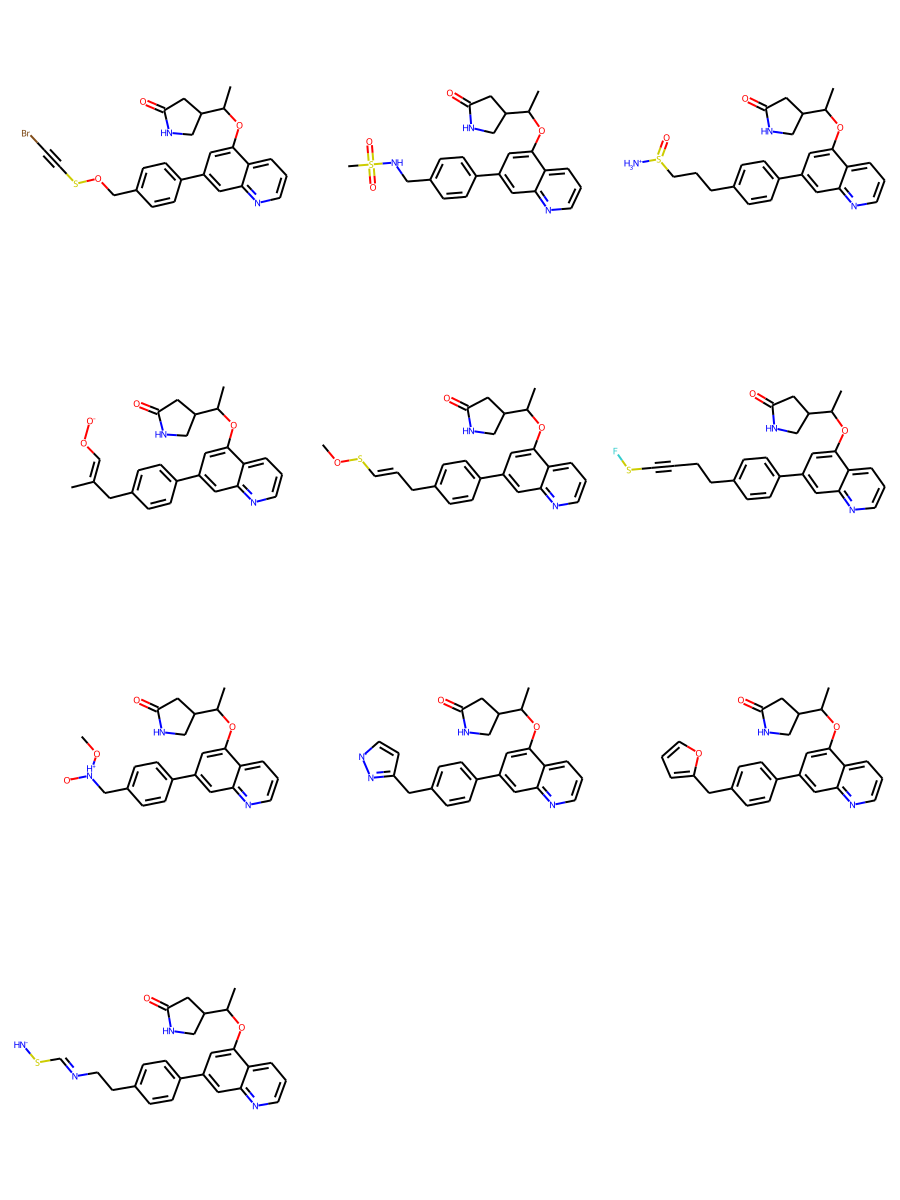

In [24]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles], molsPerRow=3, subImgSize=(300,300), 
                            legends='')  